In [47]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import statsmodels as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [48]:
# read the data
df = pd.read_csv('full_data.csv')
df.head()

,Unnamed: 0,id,Song title,Artist,Current Ranking,Number of weeks on billboard,Peak Ranking,Date,Danceability,Energy,...,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration ms,Time Signature,Artist Score
0,0,1,All I Want For Christmas Is You,Mariah Carey,1,17,1,2022-01-01,0.837,0.462,...,1.0,0.0601,0.0339,0.000000,0.0900,0.762,139.986,201400.0,4.0,79.0
1,1,2,Last Christmas,Wham!,2,15,2,2022-01-01,0.735,0.478,...,1.0,0.0293,0.1890,0.000002,0.3550,0.947,107.682,262960.0,4.0,13.0
2,2,3,Rockin' Around The Christmas Tree,Brenda Lee,3,13,3,2022-01-01,0.589,0.472,...,1.0,0.0502,0.6140,0.000000,0.5050,0.898,67.196,126267.0,4.0,58.0
3,3,4,Jingle Bell Rock,Bobby Helms,4,13,4,2022-01-01,0.754,0.424,...,1.0,0.0363,0.6430,0.000000,0.0652,0.806,119.705,130973.0,4.0,50.0
4,4,5,abcdefu,GAYLE,5,6,2,2022-01-01,0.695,0.540,...,1.0,0.0493,0.2990,0.000000,0.3670,0.415,121.932,168602.0,4.0,69.0


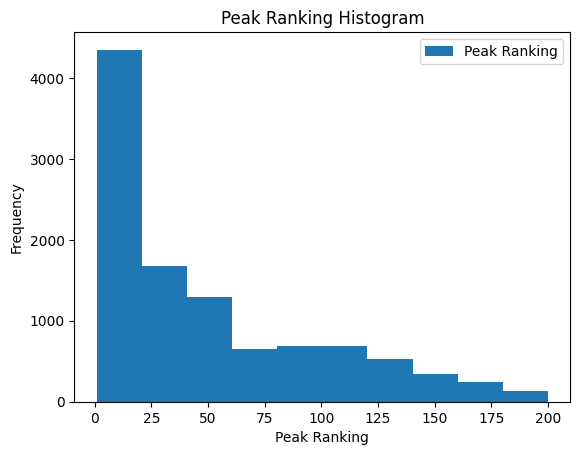

,Peak Ranking,Danceability,Key,Loudness,Energy,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration ms,Time Signature,Artist Score
Peak Ranking,1.000000,-0.158375,-0.020153,-0.046488,0.093088,0.170410,-0.021393,-0.013586,0.004602,0.049895,0.020481,0.011396,0.167263,-0.004449,-0.214867
Danceability,-0.158375,1.000000,-0.044522,0.310608,0.220702,-0.179689,0.199050,-0.306867,-0.214529,-0.208561,0.359072,-0.258003,-0.298237,0.195759,0.132528
Key,-0.020153,-0.044522,1.000000,0.012103,0.063418,-0.145650,-0.001248,0.041568,0.007510,-0.034190,0.165200,0.171898,-0.007428,-0.039599,-0.062430
Loudness,-0.046488,0.310608,0.012103,1.000000,0.734657,0.003084,-0.018079,-0.437350,-0.314866,-0.014957,0.282652,-0.099388,-0.126882,0.093472,0.159069
Energy,0.093088,0.220702,0.063418,0.734657,1.000000,0.022310,-0.012277,-0.612954,-0.212277,0.030350,0.361091,0.099849,-0.067763,0.161054,0.037793
Mode,0.170410,-0.179689,-0.145650,0.003084,0.022310,1.000000,-0.035199,0.060035,0.087196,-0.080361,0.006298,-0.022952,0.075553,-0.027680,-0.212539
Speechiness,-0.021393,0.199050,-0.001248,-0.018079,-0.012277,-0.035199,1.000000,-0.097816,0.001581,0.030014,0.086862,0.099965,-0.089574,-0.229966,-0.115412
Acousticness,-0.013586,-0.306867,0.041568,-0.437350,-0.612954,0.060035,-0.097816,1.000000,0.175085,-0.066333,-0.185986,-0.014390,-0.017080,-0.170725,-0.167264
Instrumentalness,0.004602,-0.214529,0.007510,-0.314866,-0.212277,0.087196,0.001581,0.175085,1.000000,-0.037806,-0.103761,-0.013228,-0.051565,0.023287,-0.093288
Liveness,0.049895,-0.208561,-0.034190,-0.014957,0.030350,-0.080361,0.030014,-0.066333,-0.037806,1.000000,-0.011930,-0.016733,0.018577,-0.072329,0.026948


In [49]:
peak = df.plot.hist(y='Peak Ranking')

# Set the title and labels of the plot
peak.set_title('Peak Ranking Histogram')
peak.set_xlabel('Peak Ranking')
peak.set_ylabel('Frequency')

# Show the peak ranking histogram

#plt.savefig('Peak Ranking Hist.png')
plt.show()

# From the histogram shown, we need to perfom binning

variable_list = ['Peak Ranking',
        'Danceability', 'Key', 'Loudness', 'Energy', 'Mode',  
        'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 
        'Valence', 'Tempo', 'Duration ms', 'Time Signature','Artist Score']

# Plot Correlation Matrix
corr = df[variable_list].corr()
corr.style.background_gradient(cmap='coolwarm')


# fig, ax = plt.subplots()
# sns.heatmap(df[variable_list].corr(method='pearson'), annot=False, fmt='.4f', 
#             cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
# ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
# plt.savefig('Corr Matrix.png', bbox_inches='tight', pad_inches=0.0)

In [50]:
variable_list = [
        'Key', 'Loudness', 'Mode',  
        'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 
        'Valence', 'Tempo','Artist Score']

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

x = df[variable_list]

calc_vif(x)

,variables,VIF
0,Key,3.021229
1,Loudness,8.704574
2,Mode,2.083899
3,Speechiness,2.236266
4,Acousticness,2.567586
5,Instrumentalness,1.161356
6,Liveness,2.716175
7,Valence,7.257111
8,Tempo,15.337516
9,Artist Score,15.755074


In [51]:
variable_list = [
        'Danceability', 'Key', 'Loudness', 'Mode',  
        'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 
        'Valence', 'Tempo', 'Duration ms', 'Time Signature','Artist Score']

removed_variables = ['Number of weeks on billboard','Artist','Song Title','Current Ranking', 'Energy']


X = df[variable_list]
y = df['Peak Ranking']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 109)

In [52]:
# Encode categorical features
#import label encoder
from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# cols = ['Artist', 'Song title']
# X_train[cols] = X_train[cols].apply(le.fit_transform)
# X_test[cols] = X_test[cols].apply(le.fit_transform)

# Scale continuous features
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

X_train[variable_list] = scaler.fit_transform(X_train[variable_list])

X_test[variable_list] = scaler.fit_transform(X_test[variable_list])

#create 8 equal bins for y_test & y_train
bin_y_train = pd.cut(y_train, bins=8, labels=False)
# print(bin_y_train.value_counts())

bin_y_test = pd.cut(y_test, bins=8, labels=False)
# print(bin_y_test.value_counts())

binner = [0,20,200]

bin_y_train_2 = pd.cut(y_train, bins=binner, labels=False)

bin_y_test_2 = pd.cut(y_test, bins=binner, labels=False)

print(bin_y_test_2.value_counts())






1    1838
0    1342
Name: Peak Ranking, dtype: int64


In [53]:
# Use feature selection to select the most important features
selector = SelectKBest(f_classif, k='all')
selector.fit(X_train, bin_y_train_2)
X_train = selector.transform(X_train)
X_val = selector.transform(X_test)

In [54]:
#Logistic Regression

# define the parameter grid to search over
param_grid = {'C': [0.1, 1, 10, 100]}

# perform a grid search over the parameter grid using cross-validation
lr_cv = GridSearchCV(LogisticRegression(random_state=109, multi_class='ovr'), param_grid, cv=5, scoring = 'f1_macro')
lr_cv.fit(X_train, bin_y_train_2)

# use the best hyperparameters to fit the model and make predictions on the test set
best_lr = lr_cv.best_estimator_
y_pred_lr = best_lr.predict(X_test)

# evaluate the performance of the model on the test set
print('Binary Logistic Regression Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_lr, average = 'weighted'))
print('Precision:', precision_score(bin_y_test_2, y_pred_lr, average = 'weighted'))
print('Recall:', recall_score(bin_y_test_2, y_pred_lr, average = 'weighted'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_lr))

Binary Logistic Regression Scores:
F1 Score: 0.6167896032643119
Precision: 0.632801088434824
Recall: 0.6377358490566037
Accuracy: 0.6377358490566037


c:\Users\shayer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


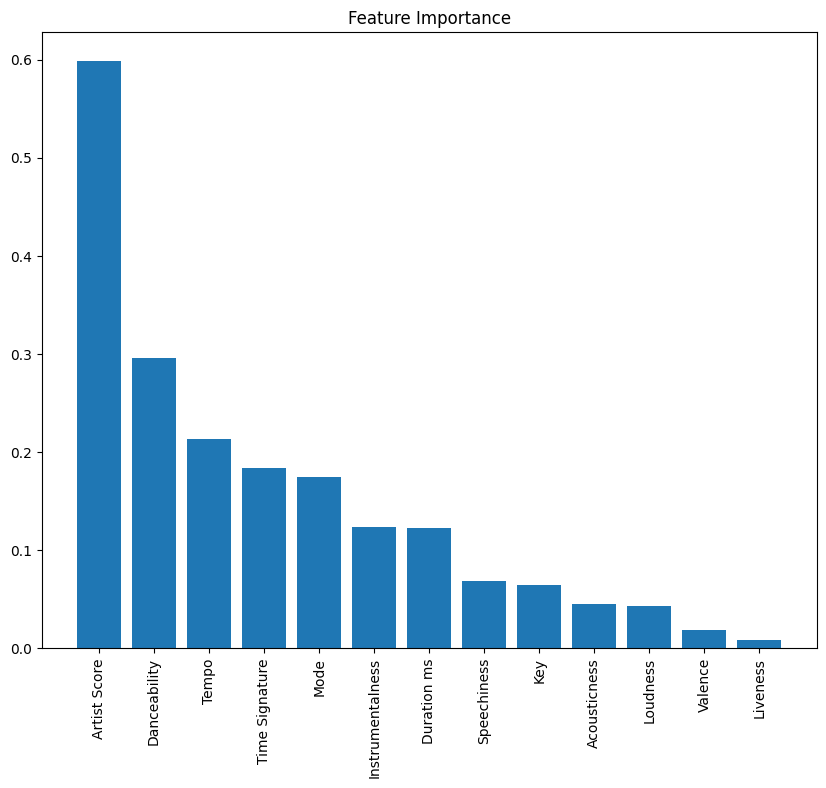

In [67]:
#old code to plot feature importance in log classifier -> not needed anymore

# # Get absolute coefficients of the logistic classifier
# coef = abs(best_lr.coef_[0])

# # Sort feature importance scores in descending order
# indices = coef.argsort()[::-1]

# # Create feature importance plot
# plt.figure(figsize=(10,8))
# plt.title("Feature Importance")
# plt.bar(range(X.shape[1]), coef[indices])
# plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
# plt.show()

In [56]:
#Support Vector Machines

# Use GridSearchCV to find the best hyperparameters for SVM
svm = SVC(random_state=109)
param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'decision_function_shape': ['ovr', 'ovo']}
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, bin_y_train_2)
svm = grid_search.best_estimator_

# # reduce the number of features using PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Train the SVM model on the selected features
svm.fit(X_train, bin_y_train_2)
y_pred_svm = svm.predict(X_test)

# Evaluate the performance of the SVM model
print('Binary Support Vector Machine Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_svm, average = 'weighted'))
print('Precision:', precision_score(bin_y_test_2, y_pred_svm, average = 'weighted'))
print('Recall:', recall_score(bin_y_test_2, y_pred_svm, average = 'weighted'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_svm))

c:\Users\shayer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Binary Support Vector Machine Scores:
F1 Score: 0.847181435830151
Precision: 0.8478808950427608
Recall: 0.8468553459119497
Accuracy: 0.8468553459119497


In [57]:
#Adaboost

# Initialize the AdaBoost model
ada = AdaBoostClassifier(random_state=109)

# Define the hyperparameters to search over using GridSearchCV
param_grid = {'learning_rate': [0.01, 0.1, 1],
              'n_estimators': [100, 500, 1000]}

# Use GridSearchCV to find the best hyperparameters for the model
grid_search = GridSearchCV(ada, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, bin_y_train_2)
ada = grid_search.best_estimator_

# Train the AdaBoost model on the selected features
ada.fit(X_train, bin_y_train_2)
y_pred_ada = ada.predict(X_test)

# Evaluate the performance of the AdaBoost model
print('Binary AdaBoost Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_ada, average='weighted'))
print('Precision:', precision_score(bin_y_test_2, y_pred_ada, average='weighted'))
print('Recall:', recall_score(bin_y_test_2, y_pred_ada, average='weighted'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_ada))

c:\Users\shayer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


Binary AdaBoost Scores:
F1 Score: 0.7511155967434918
Precision: 0.7603501417683802
Recall: 0.7575471698113208
Accuracy: 0.7575471698113208


In [58]:
#Gradient Boosting

# Initialize the Gradient Boosting model
gboost = GradientBoostingClassifier(random_state = 109)

# Define the hyperparameters to search over using GridSearchCV
param_grid = {'learning_rate': [0.01, 0.1, 1],
              'n_estimators': [100, 500, 1000],
              'max_depth': [3, 5, 7]}

# Use GridSearchCV to find the best hyperparameters for the model
grid_search = GridSearchCV(gboost, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, bin_y_train_2)
gboost = grid_search.best_estimator_

# Train the Gradient Boosting model on the selected features
gboost.fit(X_train, bin_y_train_2)
y_pred_gboost = gboost.predict(X_test)

# Evaluate the performance of the Gradient Boosting model
print('Binary Gradient Boosting Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_gboost, average='weighted'))
print('Precision:', precision_score(bin_y_test_2, y_pred_gboost, average='weighted'))
print('Recall:', recall_score(bin_y_test_2, y_pred_gboost, average='weighted'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_gboost))

Binary Gradient Boosting Scores:
F1 Score: 0.8277205239098581
Precision: 0.8294041327285502
Recall: 0.8292452830188679
Accuracy: 0.8292452830188679


c:\Users\shayer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [59]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Specify the hyperparameter grid
param_grid = {'n_estimators': [100, 150, 200],
              'max_depth': [None, 5, 10],
              'min_samples_split': [4, 5, 6],
              'min_samples_leaf': [1, 2, 4]}
# Instantiate the GridSearchCV object
grid_search_rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search_rfc.fit(X_train, bin_y_train_2)
print('Best Hyper Parameters:', grid_search_rfc.best_params_)

Best Hyper Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}


In [60]:
# Random Forest
rfc = RandomForestClassifier(max_depth=grid_search_rfc.best_params_['max_depth'], min_samples_leaf= grid_search_rfc.best_params_['min_samples_leaf'],
                              min_samples_split=grid_search_rfc.best_params_['min_samples_split'], n_estimators=grid_search_rfc.best_params_['n_estimators'], random_state=109)
rfc.fit(X_train, bin_y_train_2)
y_pred_rfc = rfc.predict(X_test)
# Evaluate the performance of the Random Forest model
print('Binary Random Forest Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_rfc, average='weighted'))
print('Precision:', precision_score(bin_y_test_2, y_pred_rfc, average='weighted'))
print('Recall:', recall_score(bin_y_test_2, y_pred_rfc, average='weighted'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_rfc))

Binary Random Forest Scores:
F1 Score: 0.8718793781038305
Precision: 0.8722177886134298
Recall: 0.8716981132075472
Accuracy: 0.8716981132075472


c:\Users\shayer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [61]:
feature_names = X.columns

importances = rfc.feature_importances_

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)

# Display the sorted DataFrame
print(importance_df)

             feature  importance
12      Artist Score    0.245265
0       Danceability    0.091453
10       Duration ms    0.086394
9              Tempo    0.081688
7           Liveness    0.079396
2           Loudness    0.078427
4        Speechiness    0.078266
8            Valence    0.072682
5       Acousticness    0.071548
6   Instrumentalness    0.050701
1                Key    0.046002
3               Mode    0.014234
11    Time Signature    0.003943


In [62]:
importance_df['cumulative_importance'] = importance_df['importance'].cumsum()
selected_features = importance_df[importance_df['cumulative_importance'] <= 0.95]['feature']
print(selected_features)

12        Artist Score
0         Danceability
10         Duration ms
9                Tempo
7             Liveness
2             Loudness
4          Speechiness
8              Valence
5         Acousticness
6     Instrumentalness
Name: feature, dtype: object


In [63]:
threshold = 0.03  # Choose an appropriate threshold value
selected_features = importance_df.loc[importance_df['importance'] >= threshold, 'feature']
print(selected_features)

12        Artist Score
0         Danceability
10         Duration ms
9                Tempo
7             Liveness
2             Loudness
4          Speechiness
8              Valence
5         Acousticness
6     Instrumentalness
1                  Key
Name: feature, dtype: object


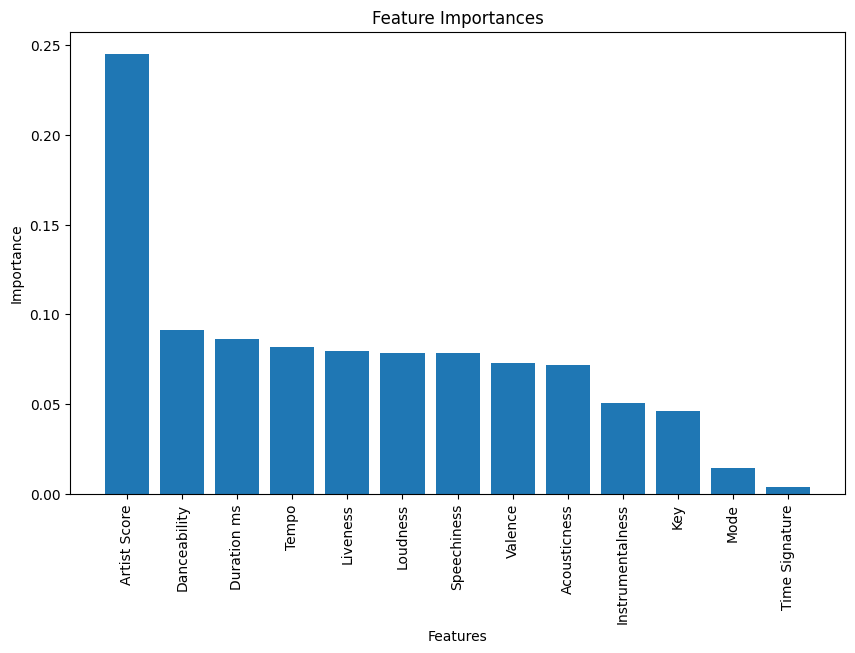

In [64]:
plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')

#plt.savefig('Feature Importance.png')
plt.show()

In [65]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Define the parameter grid to search over
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Create a GridSearchCV object with 5-fold cross-validation
grid_search_NB = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search_NB.fit(X_train, bin_y_train_2)

# Get the best hyperparameters
best_params_NB = grid_search_NB.best_params_
print(f"Best hyperparameters: {best_params_NB}")

Best hyperparameters: {'var_smoothing': 1e-09}


In [66]:
nb = GaussianNB(var_smoothing=1e-09)
nb.fit(X_train, bin_y_train_2)
y_pred_nb = nb.predict(X_test)
# Evaluate the performance of the Naive Bayes model
print('Binary Naive Bayes Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_nb, average='weighted'))
print('Precision:', precision_score(bin_y_test_2, y_pred_nb, average='weighted'))
print('Recall:', recall_score(bin_y_test_2, y_pred_nb, average='weighted'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_nb))

Binary Naive Bayes Scores:
F1 Score: 0.6286273191407514
Precision: 0.6456910392404852
Recall: 0.6267295597484277
Accuracy: 0.6267295597484277


c:\Users\shayer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


### Summary table to show the performance of the models

Precision to 3 Significant Figures

Model| F1 Score | Precision | Recall | Accuracy |
---|---|---|---|---|
Binary Logistic Regression | 0.617 | 0.632 | 0.637 | 0.637 | 
Binary Support Vector Machine | 0.847 | 0.847 | 0.846 | 0.847 | 
Binary Adaboost | 0.751 | 0.760 | 0.758 | 0.758 | 
Binary Gradient Boosting | 0.828 | 0.829 | 0.829 | 0.829 |
Binary Random Forest | 0.871 | 0.872 | 0.872 | 0.872 |
Binary Naive Bayes | 0.629 | 0.646 | 0.627 | 0.627 |
